## Flowers102: Visualization utilities

This notebook provides visualization helpers for:

- Greedy hyperparameter tuning logs
- Optuna-based tuning logs
- Ensemble evaluation metrics

Each section focuses on reading JSON or JSONL log files, grouping results, and generating Matplotlib figures for analysis.


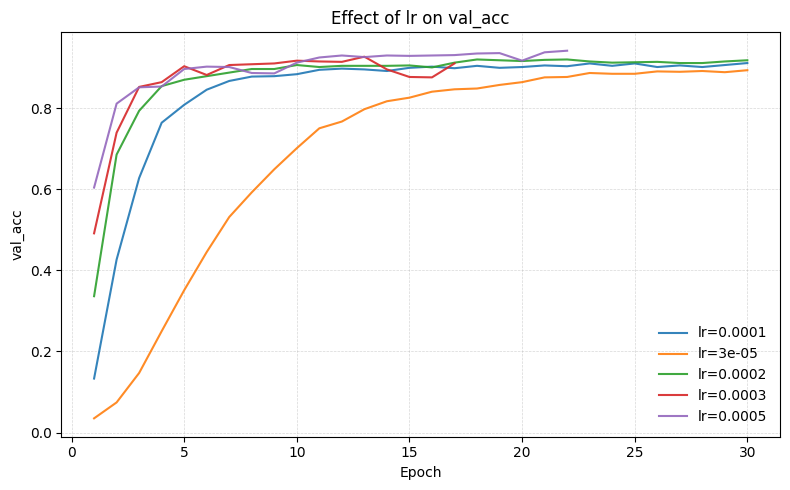

[VIS] Saved: plots\greedy_valacc_lr.png


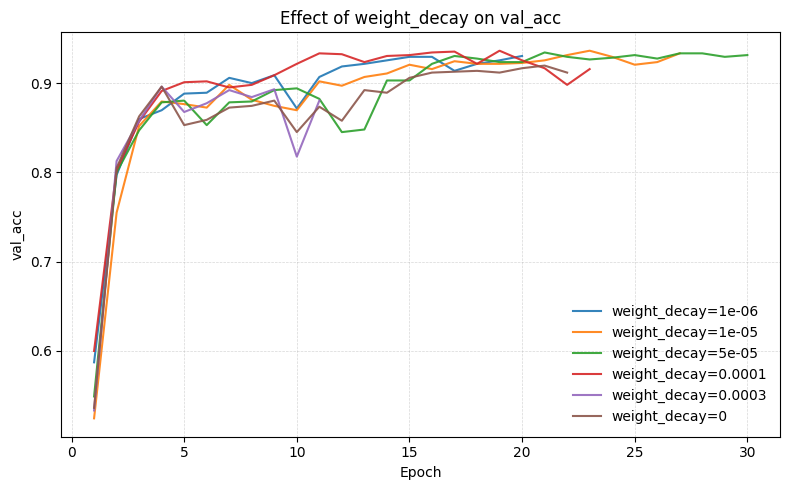

[VIS] Saved: plots\greedy_valacc_weight_decay.png


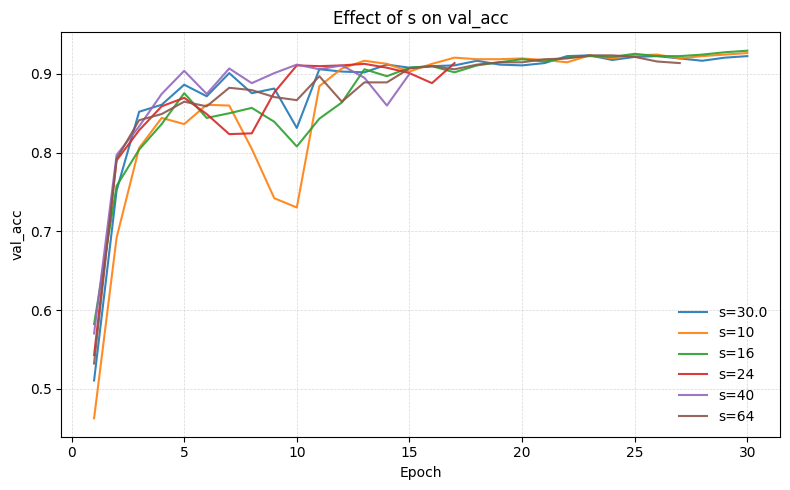

[VIS] Saved: plots\greedy_valacc_s.png


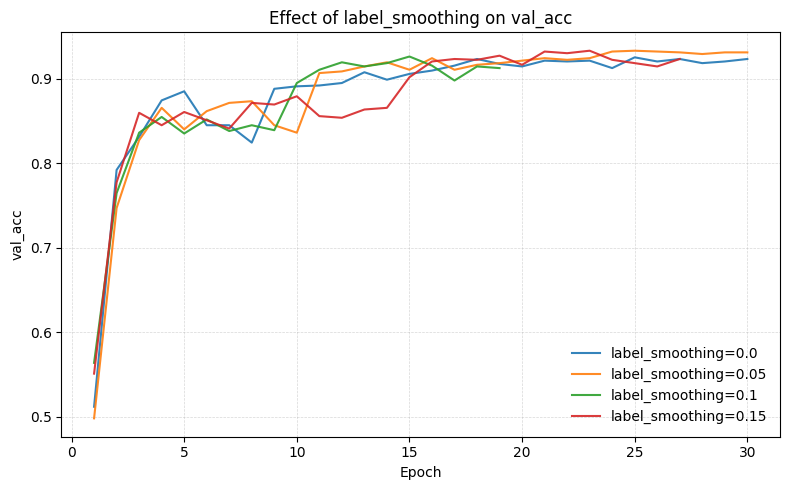

[VIS] Saved: plots\greedy_valacc_label_smoothing.png


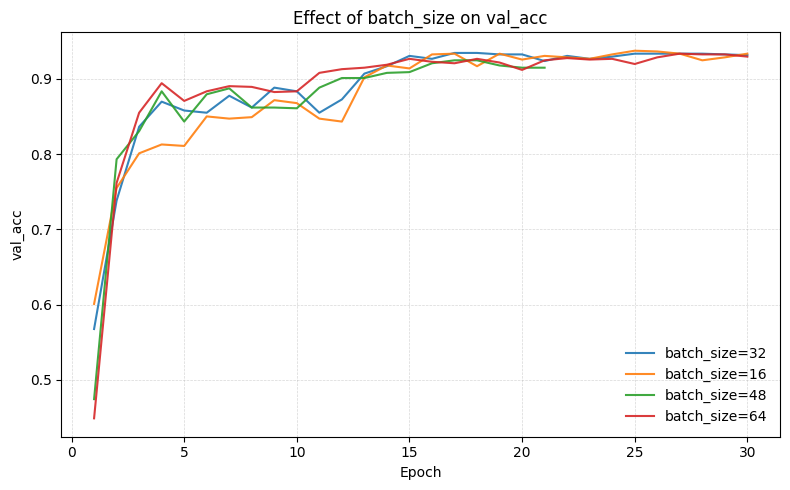

[VIS] Saved: plots\greedy_valacc_batch_size.png
[VIS] Visualization finished.


In [3]:
# =============================================================================
# 4.1 Visualization of greedy tuning
# =============================================================================
# Reads logs/train_process.jsonl and draws one line chart per parameter.

import os, json
from collections import defaultdict
from typing import Dict, Any, List
import matplotlib.pyplot as plt

def _vis_read_jsonl(path: str) -> List[Dict[str, Any]]:
    """Read a JSONL log file and return a list of dicts."""
    if not os.path.exists(path):
        print(f"[VIS] Log not found: {path}")
        return []
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                data.append(json.loads(line))
            except Exception as e:
                print(f"[VIS] Skip malformed line: {e}")
    return data

def _vis_group_by_param(records: List[Dict[str, Any]]):
    """
    Group records by parameter, value, and trial_id. Sort rows by epoch.
    Only include rows with keys: 'param', 'value', and 'trial_id'.
    """
    g = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for r in records:
        p = r.get("param")
        v = r.get("value")
        tid = r.get("trial_id")
        if p is None or v is None or tid is None:
            continue
        g[p][str(v)][tid].append(r)
    # sort by epoch
    for p in g:
        for v in g[p]:
            for tid in g[p][v]:
                g[p][v][tid] = sorted(g[p][v][tid], key=lambda x: x.get("epoch", 0))
    return g

def _vis_plot_param_curves(grouped, outdir="plots", metric="val_acc"):
    """
    For each parameter, plot metric vs. epoch for each tried value.
    Create one figure per parameter and save as PNG.
    """
    os.makedirs(outdir, exist_ok=True)
    for param, by_val in grouped.items():
        if not by_val:
            continue
        plt.figure(figsize=(8, 5))
        # Draw one curve per value (if multiple trials per value appear, draw them with reduced alpha)
        for val, trials in by_val.items():
            first = True
            for tid, rows in trials.items():
                xs = [int(r.get("epoch", 0)) for r in rows]
                ys = [float(r.get(metric, float("nan"))) for r in rows]
                plt.plot(xs, ys, alpha=0.9 if first else 0.35,
                         label=f"{param}={val}" if first else None)
                first = False

        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"Effect of {param} on {metric}")
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        # Deduplicate legend labels
        handles, labels = plt.gca().get_legend_handles_labels()
        seen, new_h, new_l = set(), [], []
        for h, l in zip(handles, labels):
            if l and l not in seen:
                seen.add(l); new_h.append(h); new_l.append(l)
        if new_l:
            plt.legend(handles=new_h, labels=new_l, loc="best", frameon=False)
        outpath = os.path.join(outdir, f"greedy_valacc_{param}.png")
        plt.tight_layout()
        plt.savefig(outpath, dpi=150)
        plt.show()
        print(f"[VIS] Saved: {outpath}")

def visualize_greedy_logs(log_path: str = "logs/train_process.jsonl"):
    """
    Read JSONL logs, group by parameter, and plot one PNG per parameter.
    """
    recs = _vis_read_jsonl(log_path)
    if not recs:
        print("[VIS] No records to visualize.")
        return
    grouped = _vis_group_by_param(recs)
    _vis_plot_param_curves(grouped, outdir="plots", metric="val_acc")
    print("[VIS] Visualization finished.")


visualize_greedy_logs("logs/train_process.jsonl")


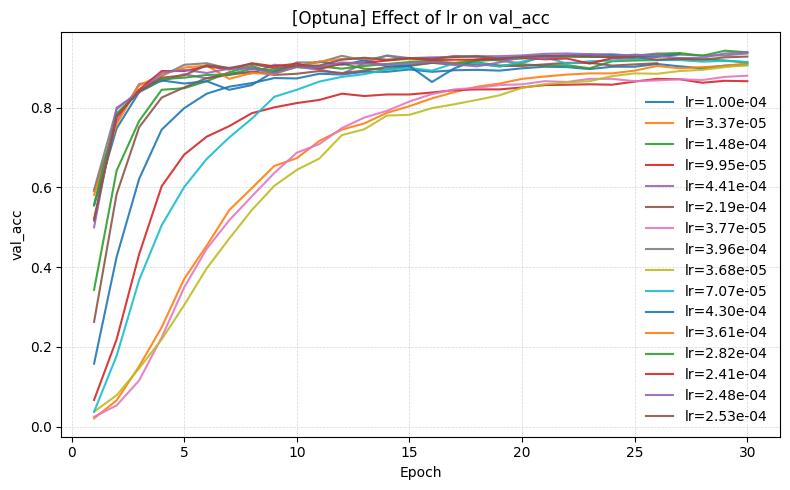

[VIS] Saved: plots\optuna_valacc_lr.png


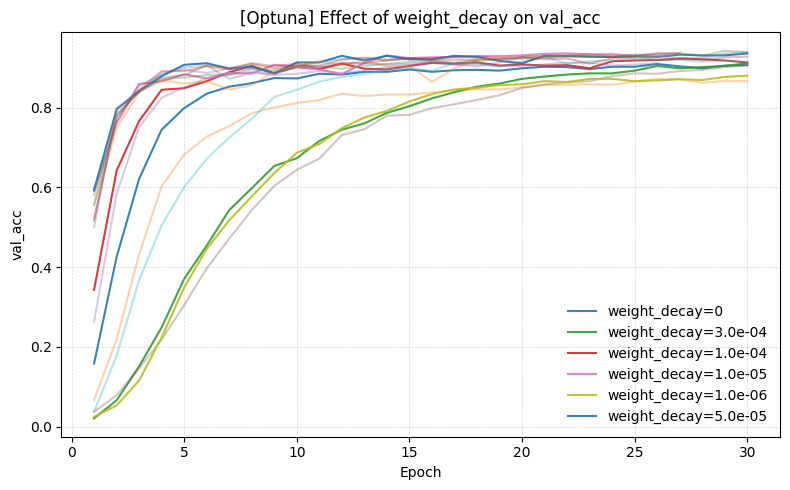

[VIS] Saved: plots\optuna_valacc_weight_decay.png


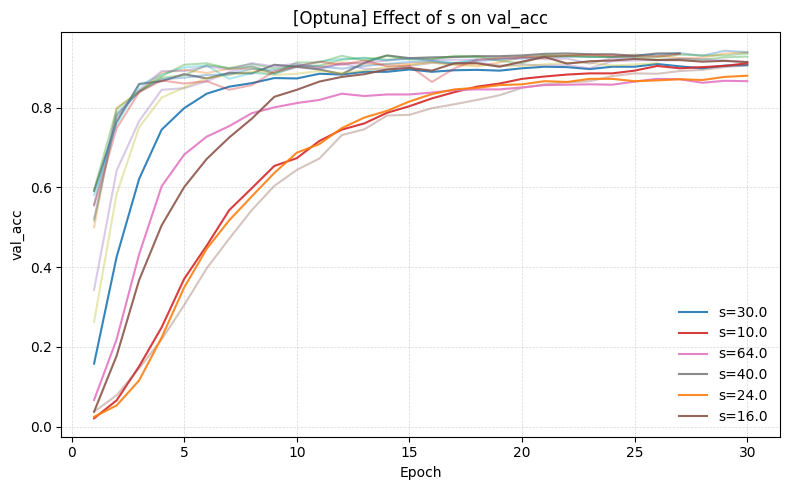

[VIS] Saved: plots\optuna_valacc_s.png


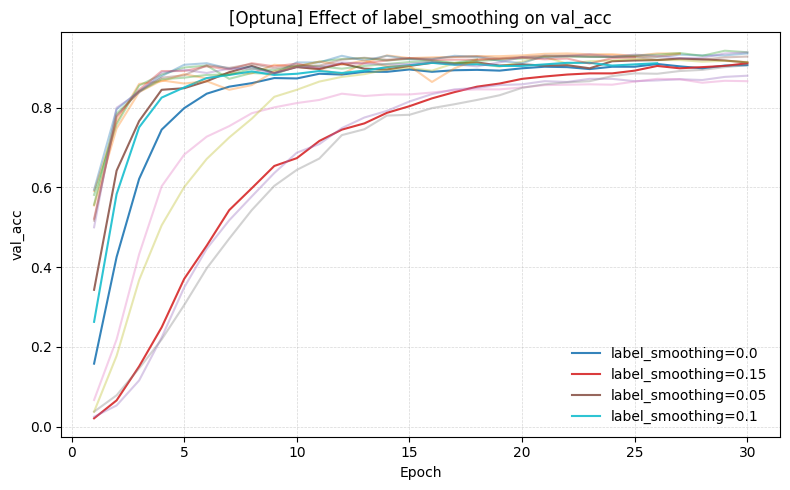

[VIS] Saved: plots\optuna_valacc_label_smoothing.png


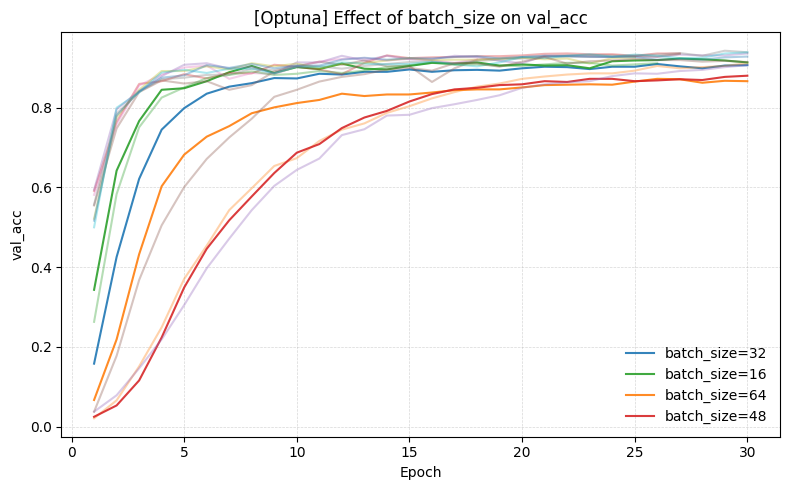

[VIS] Saved: plots\optuna_valacc_batch_size.png
[VIS] Optuna visualization finished.


In [4]:
# =============================================================================
# 4.2 Visualization of Optuna tuning 
# =============================================================================
# Reads logs/optuna_train_process.jsonl and draws one line chart per parameter.
import os, json
from collections import defaultdict
from typing import Dict, Any, List
import matplotlib.pyplot as plt
import math

# ---- Format value labels for legend (bucket continuous values for readability) ----
def _opt_vis_fmt_val(param: str, v: Any) -> str:
    """
    Produce a short, human-readable label for a param value.
    - lr: scientific notation with 2 significant digits
    - weight_decay: scientific notation with 1–2 digits; keep '0' as '0'
    - s, label_smoothing, batch_size: direct string
    """
    try:
        if param == "lr":
            # 2 significant digits, scientific notation
            return f"{float(v):.2e}"
        if param == "weight_decay":
            fv = float(v)
            if fv == 0.0:
                return "0"
            # compact scientific notation
            return f"{fv:.1e}"
        if param in ("s", "label_smoothing", "batch_size"):
            # small discrete domains
            return str(v)
    except Exception:
        pass
    return str(v)

def _opt_vis_group_by_param_from_config(
    records: List[Dict[str, Any]], params: List[str] = None
):
    """
    Group Optuna per-epoch rows by parameter -> value_label -> trial_id.
    Unlike greedy logs, Optuna rows set param='optuna', value=None,
    but contain a full 'config' dict; we expand each row into all params.
    Output shape: g[param][value_label][trial_id] = sorted rows
    """
    if params is None:
        params = ["lr", "weight_decay", "s", "label_smoothing", "batch_size"]

    g = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for r in records:
        cfg = r.get("config") or {}
        tid = r.get("trial_id")
        epoch = r.get("epoch")
        if not cfg or tid is None or epoch is None:
            continue
        for p in params:
            if p not in cfg:
                continue
            v_label = _opt_vis_fmt_val(p, cfg[p])
            g[p][v_label][tid].append(r)

    # sort by epoch
    for p in g:
        for v in g[p]:
            for tid in g[p][v]:
                g[p][v][tid] = sorted(g[p][v][tid], key=lambda x: x.get("epoch", 0))
    return g

def _opt_vis_plot_param_curves(grouped, outdir="plots", metric="val_acc"):
    """
    For each parameter, plot metric vs. epoch for each tried value.
    Save one PNG per parameter with prefix 'optuna'.
    """
    os.makedirs(outdir, exist_ok=True)
    for param, by_val in grouped.items():
        if not by_val:
            continue
        plt.figure(figsize=(8, 5))
        # Draw one curve per value (multiple trials per value -> dimmer lines after the first)
        for val, trials in by_val.items():
            first = True
            for tid, rows in trials.items():
                xs = [int(r.get("epoch", 0)) for r in rows]
                ys = [float(r.get(metric, float("nan"))) for r in rows]
                # Skip empty or all-NaN
                if not xs or all(math.isnan(y) for y in ys):
                    continue
                plt.plot(xs, ys, alpha=0.9 if first else 0.35,
                         label=f"{param}={val}" if first else None)
                first = False

        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"[Optuna] Effect of {param} on {metric}")
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        # Deduplicate legend labels
        handles, labels = plt.gca().get_legend_handles_labels()
        seen, new_h, new_l = set(), [], []
        for h, l in zip(handles, labels):
            if l and l not in seen:
                seen.add(l); new_h.append(h); new_l.append(l)
        if new_l:
            plt.legend(handles=new_h, labels=new_l, loc="best", frameon=False)
        outpath = os.path.join(outdir, f"optuna_valacc_{param}.png")
        plt.tight_layout()
        plt.savefig(outpath, dpi=150)
        plt.show()
        print(f"[VIS] Saved: {outpath}")

def visualize_optuna_logs(log_path: str = "logs/optuna_train_process.jsonl"):
    """
    Read Optuna JSONL logs and plot one PNG per parameter, mirroring greedy viz.
    """
    recs = _vis_read_jsonl(log_path)
    if not recs:
        print("[VIS] No Optuna records to visualize.")
        return
    grouped = _opt_vis_group_by_param_from_config(recs)
    _opt_vis_plot_param_curves(grouped, outdir="plots", metric="val_acc")
    print("[VIS] Optuna visualization finished.")


visualize_optuna_logs("logs/optuna_train_process.jsonl")


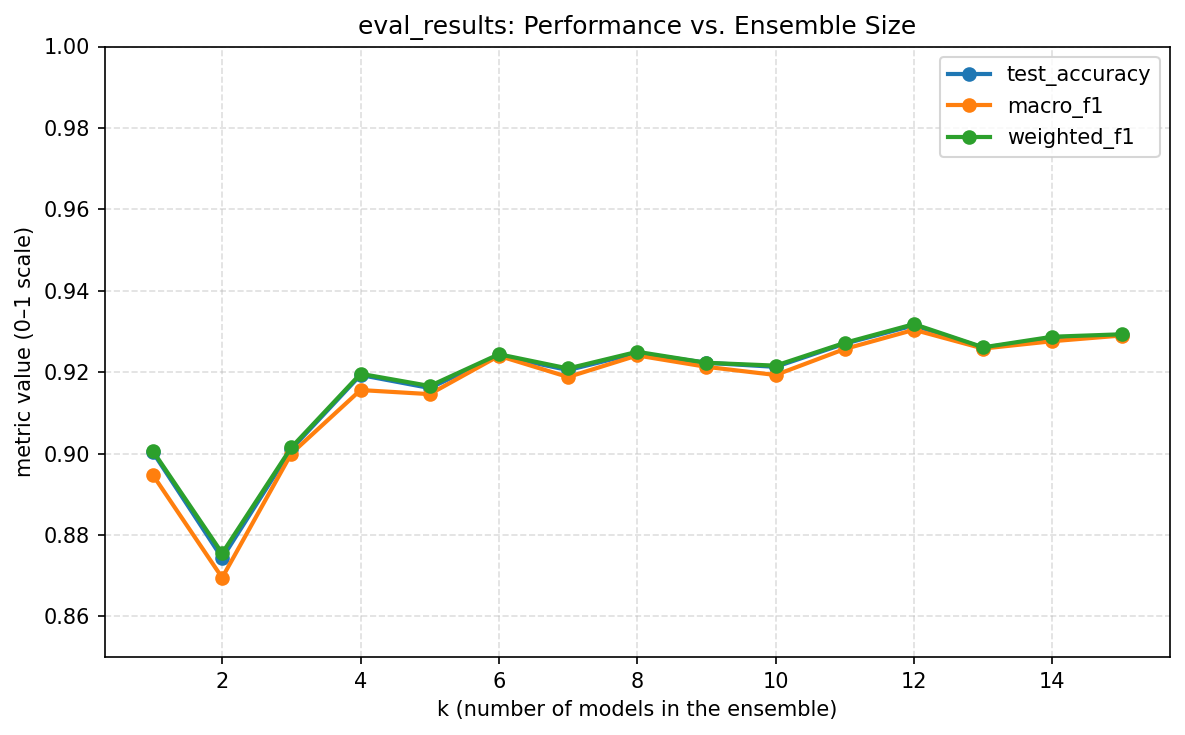

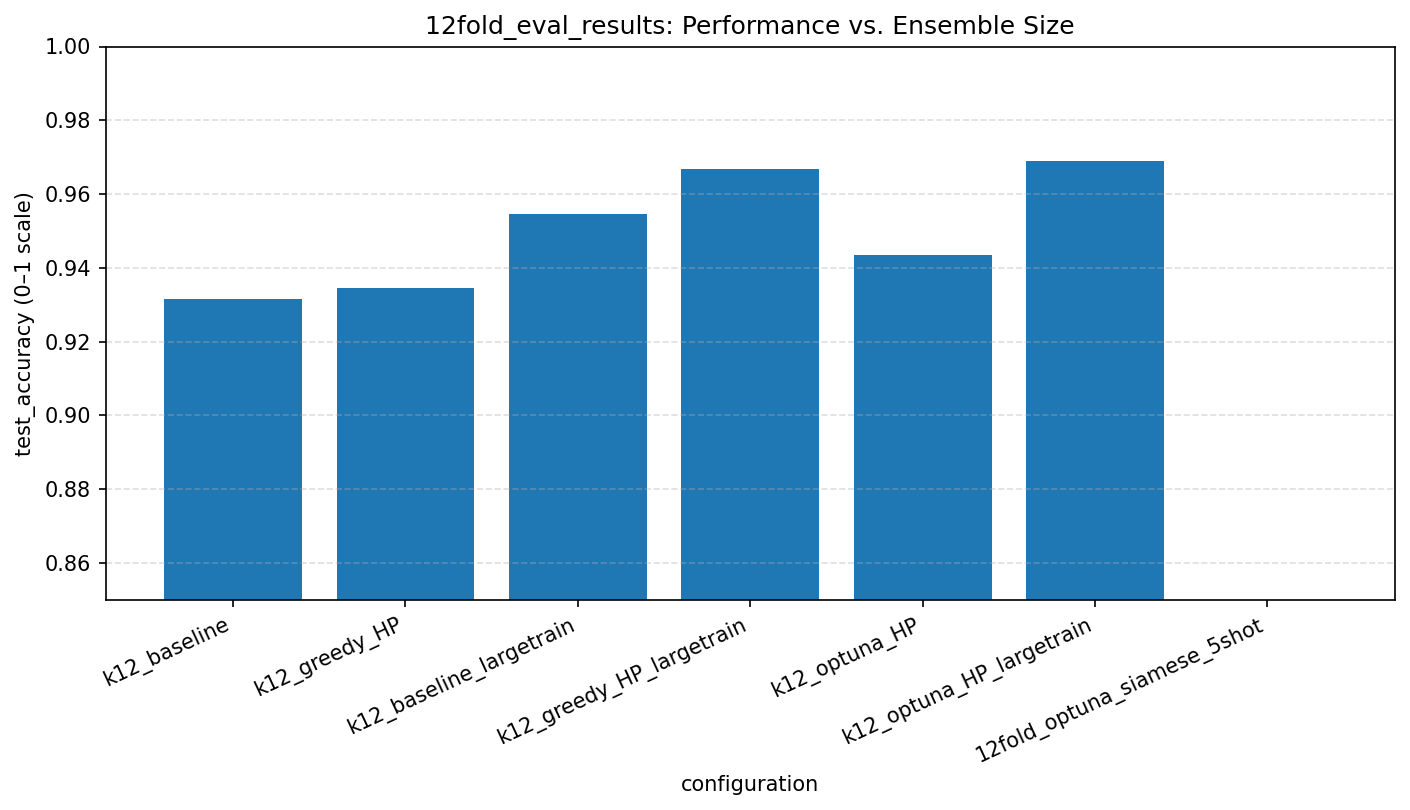

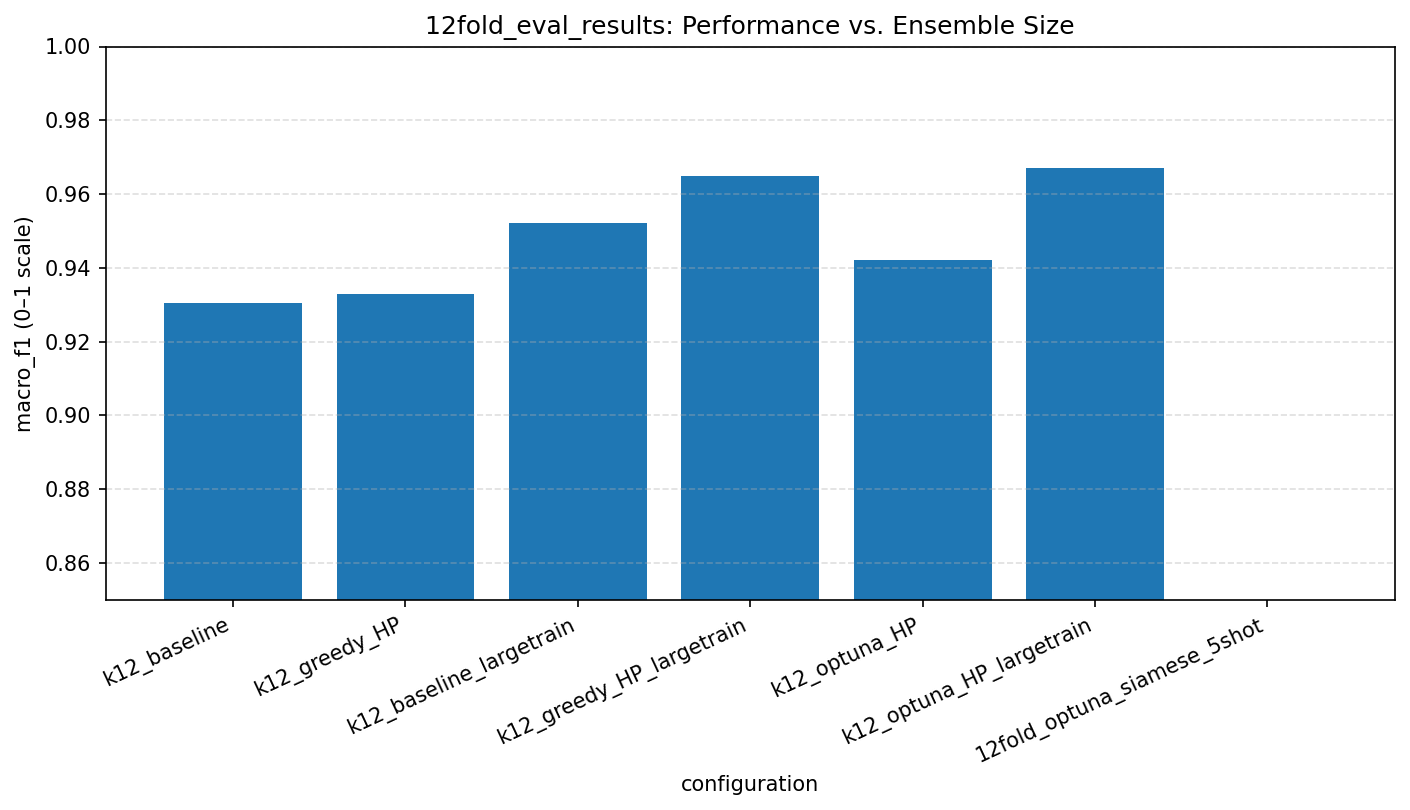

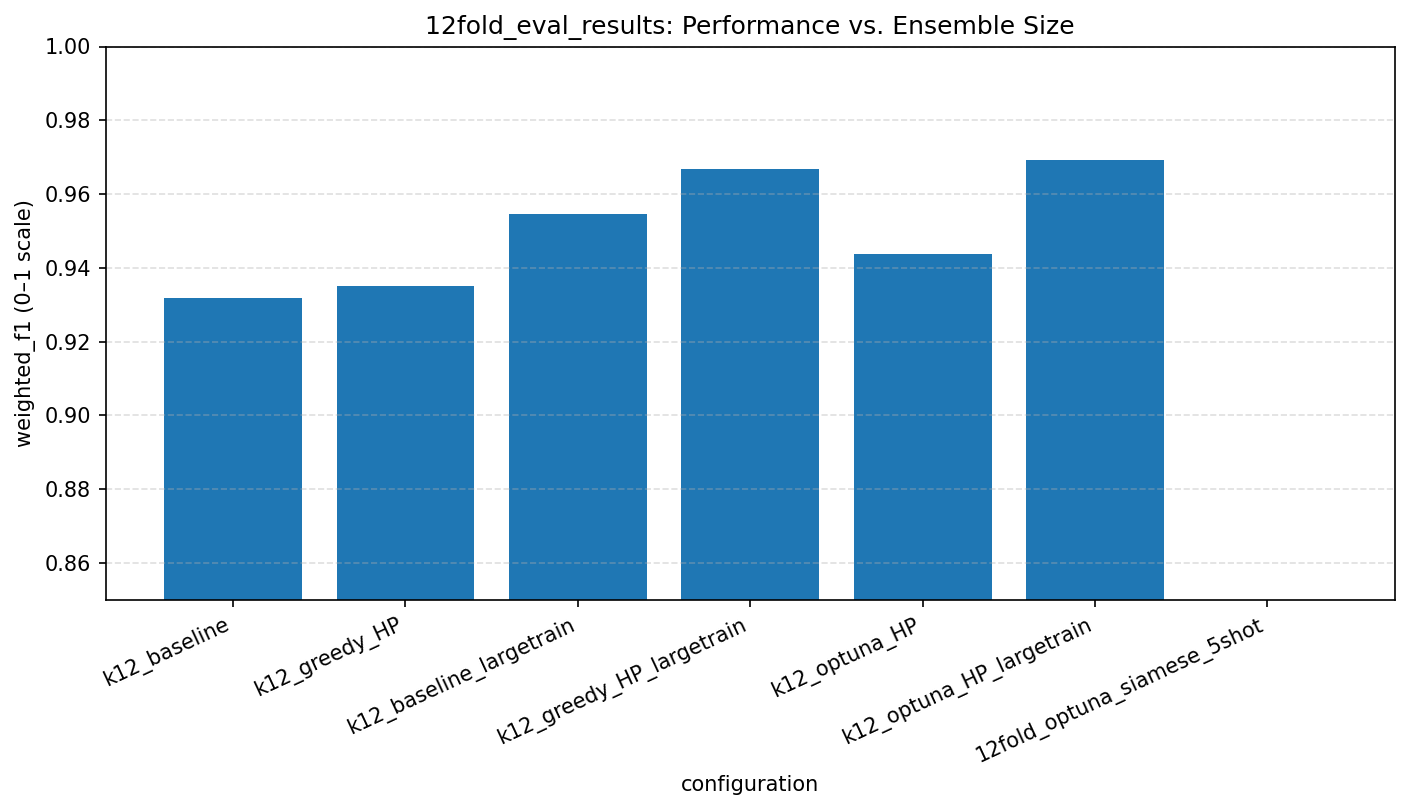

[WindowsPath('12fold_ensemble_ckpt/12fold_eval_results_test_accuracy_bar.png'),
 WindowsPath('12fold_ensemble_ckpt/12fold_eval_results_macro_f1_bar.png'),
 WindowsPath('12fold_ensemble_ckpt/12fold_eval_results_weighted_f1_bar.png')]

In [ ]:
# =============================================================================
# 4.3 Visualization of test Accuracies of Single-Model and 12-Fold Ensemble Configurations 
# =============================================================================


import json
from pathlib import Path
from typing import Dict, Any, List, Tuple

import matplotlib.pyplot as plt


EVAL_PATH = "./ensemble_ckpt/eval_results.json"
OUT_JSON = "./12fold_ensemble_ckpt/12fold_eval_results.json"

# Y-axis limits to zoom into [0.85, 1.0]
Y_MIN, Y_MAX = 0.85, 1.0

# Metrics to visualize
METRICS = ["test_accuracy", "macro_f1", "weighted_f1"]


def load_json(path: str | Path) -> Dict[str, Any]:
    """Load a JSON file and return the parsed object."""
    p = Path(path)
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def figure_title_prefix(path: str | Path) -> str:
    """Use file stem as the title prefix, e.g., 'eval_results' or '12fold_eval_results'."""
    return Path(path).stem


def output_path_like_input(input_path: str | Path, suffix: str) -> Path:
    """
    Build an output PNG path next to the input JSON.
    Example:
        input: /a/b/eval_results.json, suffix="_line"
        output: /a/b/eval_results_line.png
    """
    ip = Path(input_path)
    return ip.with_name(f"{ip.stem}{suffix}.png")


def parse_eval_results_for_lines(eval_data: Dict[str, Any]) -> Tuple[List[int], Dict[str, List[float]]]:
    """
    Convert eval_results.json structure into sorted x values (k) and metric series.
    Assumes top-level keys like 'k1', 'k2', ..., each containing num_models and metric fields.
    """
    # Collect (k, metrics) pairs
    points: List[Tuple[int, Dict[str, float]]] = []
    for key, val in eval_data.items():
        if not isinstance(val, dict):
            continue
        # Accept entries that look like 'k<number>' and contain metrics
        if key.startswith("k") and "num_models" in val:
            k = int(val["num_models"])
            points.append((k, {m: float(val.get(m, float("nan"))) for m in METRICS}))

    # Sort by k
    points.sort(key=lambda x: x[0])

    ks = [k for k, _ in points]
    series: Dict[str, List[float]] = {m: [metrics[m] for _, metrics in points] for m in METRICS}
    return ks, series


def plot_eval_line_chart(eval_json_path: str | Path) -> Path:
    """Create the line chart for eval_results.json and save as PNG next to the file."""
    data = load_json(eval_json_path)
    ks, series = parse_eval_results_for_lines(data)

    title_prefix = figure_title_prefix(eval_json_path)
    out_png = output_path_like_input(eval_json_path, suffix="_line")

    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
    for metric in METRICS:
        ax.plot(ks, series[metric], marker="o", linewidth=2, label=metric)

    ax.set_title(f"{title_prefix}: Performance vs. Ensemble Size")
    ax.set_xlabel("k (number of models in the ensemble)")
    ax.set_ylabel("metric value (0–1 scale)")
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    fig.tight_layout()

    # Save the figure
    fig.savefig(out_png, bbox_inches="tight")
    plt.show(fig)

    return out_png


def parse_12fold_for_bars(k12_data: Dict[str, Any]) -> Tuple[List[str], Dict[str, List[float]]]:
    """
    Convert 12fold_eval_results.json structure into:
        - names: list of configuration labels (X-axis)
        - series: dict metric -> list of values aligned with names
    Exclude key '_disabled_12fold_optuna_siamese_5shot'.
    """
    names: List[str] = []
    # Initialize storage for metrics
    series: Dict[str, List[float]] = {m: [] for m in METRICS}

    for key, val in k12_data.items():
        if not isinstance(val, dict):
            continue
        if key == "_disabled_12fold_optuna_siamese_5shot":
            continue

        # Keep the entry
        names.append(key)
        for m in METRICS:
            series[m].append(float(val.get(m, float("nan"))))

    return names, series


def plot_12fold_bar_charts(k12_json_path: str | Path) -> List[Path]:
    """
    Create three bar charts (one per metric) for 12fold_eval_results.json.
    Saves PNGs next to the JSON input. Returns list of saved paths.
    """
    data = load_json(k12_json_path)
    names, series = parse_12fold_for_bars(data)

    title_prefix = figure_title_prefix(k12_json_path)
    saved_paths: List[Path] = []

    # X positions for bars
    x = list(range(len(names)))

    for metric in METRICS:
        fig, ax = plt.subplots(figsize=(9.5, 5.5), dpi=150)
        ax.bar(x, series[metric])

        ax.set_title(f"{title_prefix}: Performance vs. Ensemble Size")
        ax.set_xlabel("configuration")
        # Reflect metric in y-axis label as requested
        ax.set_ylabel(f"{metric} (0–1 scale)")
        ax.set_ylim(Y_MIN, Y_MAX)

        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=25, ha="right")

        ax.grid(True, axis="y", linestyle="--", alpha=0.4)
        fig.tight_layout()

        out_png = output_path_like_input(k12_json_path, suffix=f"_{metric}_bar")
        fig.savefig(out_png, bbox_inches="tight")
        plt.show(fig)

        saved_paths.append(out_png)

    return saved_paths


plot_eval_line_chart(EVAL_PATH)
plot_12fold_bar_charts(OUT_JSON)